In [1]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.callbacks import EarlyStopping
from matplotlib import pyplot
#from keras.callbacks import ModelCheckpoint
#from keras.models import load_model
import numpy as np



class GradeData:
    
    def __init__(self, xml_file_name):
        self.root = ET.parse(os.path.join("data", xml_file_name)).getroot()
        self.answer = []
        self.question = []
        self.label = []
        self.referance_answers = []
        self.labels_final = []
        self.referance_answers_final = []
        
    def _clean_xml(self):
        """Function that returns a tuple of lists of
        answers, questions, labels, referance answers
        """
        for ans in self.root.iter('Answer'):
            self.answer.append(ans.text)
        for que in self.root.iter('Question'):
            self.question.append(que.text)
        for lab in self.root.iter('Annotation'):
            self.label.append(lab.attrib['Label'])
        for ref in self.root.iter('ReferenceAnswers'):
            self.referance_answers.append(ref.text)    
    
    def _clean_labels(self):
        correct = [entry[0] for entry in [lab.split("|") for lab in self.label]]
        correct_but_incomplete = [entry[1] for entry in [lab.split("|") for lab in self.label]]
        contradictory = [entry[2] for entry in [lab.split("|") for lab in self.label]]    
        incorrect = [entry[3] for entry in [lab.split("|") for lab in self.label]]
    
        #filter label lists for appropiate label
        for lab in zip(correct,correct_but_incomplete,contradictory,incorrect):
            for i in lab:
                if i[-2]=='1':
                    self.labels_final.append(i[:-3])
    
    def _clean_ref_ans(self):
        for refAns in self.referance_answers:
            new_list = refAns.split("\n")[1:-1]
            self.referance_answers_final.append([entry[4:] for entry in new_list])
            
    def output(self):
        self._clean_xml()
        self._clean_labels()
        self._clean_ref_ans()
        return pd.DataFrame(list(zip(self.answer, self.question, self.labels_final, self.referance_answers_final)),
                           columns =['answer', 'question', 'label', 'refAnswers'])

In [2]:
df = GradeData('grade_data.xml').output()

In [3]:
df['refAnswers'] = df['refAnswers'].str.join(' ')
df.head()

,answer,question,label,refAnswers
0,the windshield will apply a force to the mosqu...,How does Newton's third law apply to this situ...,correct_but_incomplete,Since the windshield exerts a force on the mos...
1,The normal force coming from the ice and the g...,What forces are acting on the puck while the p...,correct,The forces acting on the puck while it is betw...
2,"if there is a zero net force on the object, th...",Can you articulate Newton's second law?,incorrect,Newton's 2nd Law says that the net force is eq...
3,An equal force always balancing it out regardl...,Can you articulate a principle or definition w...,incorrect,"For every action, there is an equal and opposi..."
4,The speed of the puck will equal to the net fo...,"Based on Newton's first law, what can you say ...",incorrect,The puck will move in a straight line with a c...


In [4]:
# create vocabulary list called flat_list
flat_list = []
for index, row in df.iterrows():
    flat_list.append(row['answer'])
    flat_list.append(row['question'])
    flat_list.append(row['refAnswers'])

In [5]:
X = df.drop(['label'],axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(flat_list)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
trunc_type='post'
oov_tok = "<OOV>"
max_length = 100

ans_sequences = tokenizer.texts_to_sequences(X_train['answer'])
ques_sequences = tokenizer.texts_to_sequences(X_train['question'])
ref_sequences = tokenizer.texts_to_sequences(X_train['refAnswers'])

ans_padded = pad_sequences(ans_sequences,maxlen=max_length, truncating=trunc_type)
ques_padded = pad_sequences(ques_sequences,maxlen=max_length, truncating=trunc_type)
ref_padded = pad_sequences(ref_sequences,maxlen=2*max_length, truncating=trunc_type)

ans_sequences_test = tokenizer.texts_to_sequences(X_test['answer'])
ques_sequences_test = tokenizer.texts_to_sequences(X_test['question'])
ref_sequences_test = tokenizer.texts_to_sequences(X_test['refAnswers'])

ans_padded_test = pad_sequences(ans_sequences_test,maxlen=max_length, truncating=trunc_type)
ques_padded_test = pad_sequences(ques_sequences_test,maxlen=max_length, truncating=trunc_type)
ref_padded_test = pad_sequences(ref_sequences_test,maxlen=2*max_length, truncating=trunc_type)

In [7]:
embeddings_index = {}
with open(os.path.join('embeddings/glove.6B', 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
num_words = min(vocab_size, len(word_index)) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2, l1

embedding_layer = Embedding(len(word_index)+1,
                           100,input_length=200,weights=[embedding_matrix],trainable=False)

left_input = Input(shape=(200, ), name='left_input')
left_branch_1 = embedding_layer(left_input)
left_branch = LSTM(100, name='left_branch')(left_branch_1)

right_input = Input(shape=(200,), name='right_input')
right_branch_1 = embedding_layer(right_input)
right_branch = LSTM(100, name='right_branch')(right_branch_1)

x = concatenate([left_branch, right_branch])
x = Dense(50, kernel_regularizer=l2(l=0.2))(x)
x = Dropout(0.1)(x)
predictions = Dense(4, activation='softmax', name='main_output')(x)

model = Model(inputs=[left_input, right_input], outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 200)]        0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     68100       left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
left_branch (LSTM)              (None, 100)          80400       embedding_2[0][0]          

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

num_epochs = 100

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit([[np.concatenate((i,j),axis=0) for i, j in zip(ans_padded, ques_padded)], ref_padded], 
                    pd.get_dummies(y_train),
                    epochs=num_epochs, 
                    validation_data=([[np.concatenate((i,j),axis=0) for i, j in zip(ans_padded_test, ques_padded_test)], ref_padded_test], 
                                       pd.get_dummies(y_test)), 
                    callbacks=[es,mc])

Train on 718 samples, validate on 180 samples
Epoch 1/100
224/718 [========>.....................] - ETA: 7s - loss: 16.1921 - accuracy: 0.3036
Epoch 00001: val_accuracy improved from -inf to 0.40556, saving model to best_model.h5
224/718 [========>.....................] - ETA: 3s - loss: 14.1528 - accuracy: 0.4420
Epoch 00002: val_accuracy improved from 0.40556 to 0.41667, saving model to best_model.h5
224/718 [========>.....................] - ETA: 2s - loss: 12.4629 - accuracy: 0.3884
Epoch 00003: val_accuracy improved from 0.41667 to 0.46667, saving model to best_model.h5
206/718 [=======>......................] - ETA: 3s - loss: 10.8946 - accuracy: 0.3641
Epoch 00004: val_accuracy did not improve from 0.46667
224/718 [========>.....................] - ETA: 2s - loss: 9.5614 - accuracy: 0.4107
Epoch 00005: val_accuracy did not improve from 0.46667
224/718 [========>.....................] - ETA: 2s - loss: 8.3201 - accuracy: 0.4732
Epoch 00006: val_accuracy did not improve from 0.46

206/718 [=======>......................] - ETA: 3s - loss: 1.2661 - accuracy: 0.5000
Epoch 00030: val_accuracy did not improve from 0.48333
224/718 [========>.....................] - ETA: 2s - loss: 1.2806 - accuracy: 0.4286
Epoch 00031: val_accuracy did not improve from 0.48333
224/718 [========>.....................] - ETA: 3s - loss: 1.2732 - accuracy: 0.4152
Epoch 00032: val_accuracy did not improve from 0.48333
206/718 [=======>......................] - ETA: 3s - loss: 1.2287 - accuracy: 0.4709
Epoch 00033: val_accuracy did not improve from 0.48333
224/718 [========>.....................] - ETA: 2s - loss: 1.2698 - accuracy: 0.4688
Epoch 00034: val_accuracy did not improve from 0.48333
224/718 [========>.....................] - ETA: 2s - loss: 1.2187 - accuracy: 0.4821
Epoch 00035: val_accuracy did not improve from 0.48333
224/718 [========>.....................] - ETA: 2s - loss: 1.2360 - accuracy: 0.4107
Epoch 00036: val_accuracy did not improve from 0.48333
206/718 [=======>...

224/718 [========>.....................] - ETA: 2s - loss: 1.1922 - accuracy: 0.4643
Epoch 00059: val_accuracy did not improve from 0.51111
206/718 [=======>......................] - ETA: 3s - loss: 1.1606 - accuracy: 0.4612
Epoch 00060: val_accuracy did not improve from 0.51111
224/718 [========>.....................] - ETA: 2s - loss: 1.2347 - accuracy: 0.4420
Epoch 00061: val_accuracy did not improve from 0.51111
224/718 [========>.....................] - ETA: 3s - loss: 1.1615 - accuracy: 0.4643
Epoch 00062: val_accuracy did not improve from 0.51111
206/718 [=======>......................] - ETA: 4s - loss: 1.2136 - accuracy: 0.4223
Epoch 00063: val_accuracy did not improve from 0.51111
224/718 [========>.....................] - ETA: 2s - loss: 1.1244 - accuracy: 0.5268
Epoch 00064: val_accuracy did not improve from 0.51111
224/718 [========>.....................] - ETA: 2s - loss: 1.2087 - accuracy: 0.4420
Epoch 00065: val_accuracy did not improve from 0.51111
206/718 [=======>...

224/718 [========>.....................] - ETA: 2s - loss: 1.1455 - accuracy: 0.4955
Epoch 00088: val_accuracy did not improve from 0.51111
206/718 [=======>......................] - ETA: 2s - loss: 1.1684 - accuracy: 0.4757
Epoch 00089: val_accuracy did not improve from 0.51111
224/718 [========>.....................] - ETA: 2s - loss: 1.1598 - accuracy: 0.4509
Epoch 00090: val_accuracy did not improve from 0.51111
224/718 [========>.....................] - ETA: 2s - loss: 1.1542 - accuracy: 0.5000
Epoch 00091: val_accuracy did not improve from 0.51111
206/718 [=======>......................] - ETA: 3s - loss: 1.2193 - accuracy: 0.4563
Epoch 00092: val_accuracy did not improve from 0.51111
224/718 [========>.....................] - ETA: 3s - loss: 1.1726 - accuracy: 0.4330
Epoch 00093: val_accuracy did not improve from 0.51111
224/718 [========>.....................] - ETA: 3s - loss: 1.1558 - accuracy: 0.4911
Epoch 00094: val_accuracy did not improve from 0.51111
224/718 [========>..

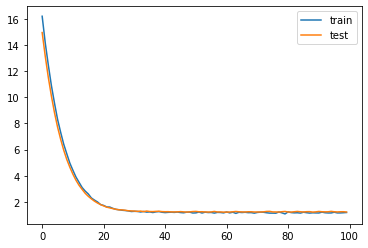

In [35]:
from tensorflow.keras.models import load_model

saved_model = load_model(os.path.join("model", 'best_model.h5'))

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [17]:
_, train_acc = model.evaluate([[np.concatenate((i,j),axis=0) for i, j in zip(ans_padded, ques_padded)], ref_padded], pd.get_dummies(y_train), verbose=0)
_, test_acc = model.evaluate([[np.concatenate((i,j),axis=0) for i, j in zip(ans_padded_test, ques_padded_test)], ref_padded_test], pd.get_dummies(y_test), verbose=0)

In [18]:
print(train_acc, test_acc)

0.5223214 0.51111114


In [36]:
"""
# save model, uncomment when required

model_json = model.to_json()
with open(os.path.join("model", "lstm_model.json"), "w") as json_file:
    json_file.write(model_json)
"""